# PTEN loss Survival Analysis for GBM

Imports

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # merge cnv with genotype all mut type
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor') # drop Normal samples

        prot_df = prot_and_mutations.iloc[:,:-4] #drop Mutation and Location cols
        mut_type = mut_type[['Mutation']] # Get Mutation col that includes CNV
        merged = prot_df.join(mut_type) # merge 

        # Create Truncation category and keep truncation and wt
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [4]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [5]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS']
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols
    # Need more cols
    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
        print('2 deaths - not enough data')
        return 0
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 
        # convert to days? Date of Last Contact (Do not answer if patient is deceased)', 'Date of Death'
        return 0
    
    
    # Get cols from followup or clinical 
    data_in_cinical = ['gbm', 'ovarian']
    if cancer not in data_in_cinical:
        df = cancer_object.get_followup()
        #print('from followup:', df[cols].columns, '\n')
    else:
        df = cancer_object.get_clinical()
        #print('from clinical:', df[cols].columns, '\n')
    
    # Make col names consistent and keep survival cols
    consistent = df.rename(columns = {cols[0]: 'vital_status', cols[1]:'days_to_last_contact',
                                        cols[2]: 'days_to_death'})
    survival_df = consistent[['vital_status', 'days_to_last_contact', 'days_to_death']]
    
    #print(survival_df['vital_status'].value_counts())
        
    return survival_df

# Step 1: Import data

In [6]:
g = cptac.Gbm()
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()

# Step 2: Get df with PTEN mutation status and clinical data

In [7]:
cancer_obj = {'GBM': g, 'HNSCC':h, 'LUAD':l, 'OV':o, 'EC': en} # info needed 'LSCC':ls, 'BR':b, 'CO':col
dfs = {}

for cancer in cancer_obj:
    df = get_survival_cols(cancer_obj[cancer]) # get 'vital_status', 'days_to_last_contact', 'days_to_death'
    
    del_wt = all_prot_format_df(cancer_obj[cancer], ['PTEN']) # get Mutation col (PTEN del/wt)
    mut_survival = del_wt.join(df, on = 'Patient_ID', how = 'left') # combine keeping only turmors
    dfs[cancer] = mut_survival

# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

In [8]:
formatted_dfs = {}

for cancer in dfs:
    df = dfs[cancer]
    #Make the vital_status column boolean
    df['vital_status'] = df['vital_status'].replace('Living', False)
    df['vital_status'] = df['vital_status'].replace('Deceased', True)
    df['vital_status'] = df['vital_status'].astype('bool')
    
    # Create one column with days between last contact or death
    days = ['days_to_last_contact', 'days_to_death']
    new_df = df.assign(days_to_last_contact_or_death = df[days].sum(1)).drop(days, 1)
    formatted_dfs[cancer] = new_df

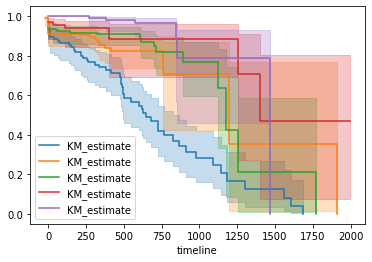

In [9]:
# Plot
for cancer in formatted_dfs:
    plot_df = formatted_dfs[cancer]
    time = plot_df['days_to_last_contact_or_death']
    status = plot_df['vital_status']

    kmf = KaplanMeierFitter()
    kmf.fit(time, event_observed = status)
    kmf.plot()

# Step 4: Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [10]:
new_dfs = {}

# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 1, "Deletion" : 2}
endo_mutation_map = {"Wildtype_Tumor" : 1, "Truncation" : 2}

for c in formatted_dfs:
    df_genes = formatted_dfs[c]
    if c not in ('EC'):
        df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)
    else:
        df_genes['PTEN'] = df_genes['Mutation'].map(endo_mutation_map)
        
    #Then we will drop missing values, as missing values 
    #will throw an error in the functions we will use in lifelines.
    df_clean = df_genes.dropna(axis=0, how='any').copy()
    df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)
    
    new_dfs[c] = df_clean

Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [11]:
for c in new_dfs:
    print(c)
    nd = new_dfs[c]
    for col in nd.columns:
        print(col, ":", nd[col].dtype)
    print('\n')

GBM
PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64


HNSCC
PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64


LUAD
PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64


OV
PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64


EC
PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64




# Step 5: Plot Multivariate Survival Risk

1 is wt. 2 is mutant.

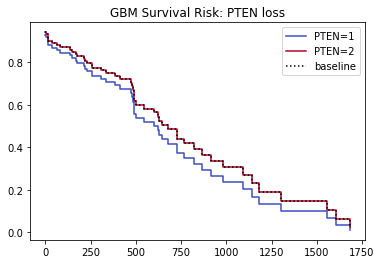

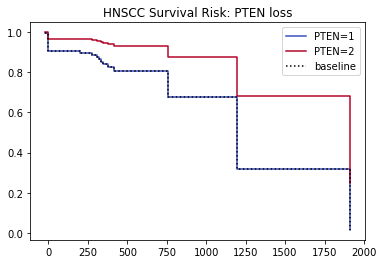

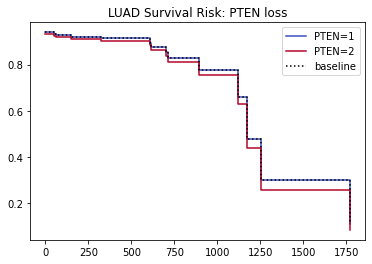

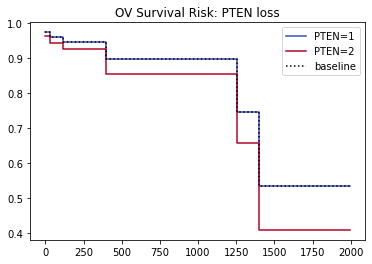

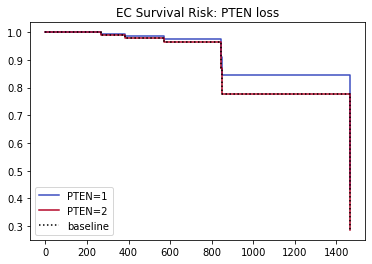

In [18]:
for cancer in new_dfs:
    df = new_dfs[cancer]

    cph = CoxPHFitter()
    cph.fit(df, duration_col = "days_to_last_contact_or_death", 
            event_col = "vital_status")

    plot_title = cancer+" Survival Risk: PTEN loss"
    cph.plot_partial_effects_on_outcome('PTEN', [1,2], cmap='coolwarm', title=plot_title)
    

In [16]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 143 total observations, 137 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 143
number of events observed = 6
   partial log-likelihood = -18.225
         time fit was run = 2020-10-09 20:53:10 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PTEN       0.406      1.501      1.125           -1.800            2.611                0.165               13.619

              z     p   -log2(p)
covariate                       
PTEN      0.361 0.718      0.477
---
Concordance = 0.500
Partial AIC = 38.451
log-likelihood ratio test = 0.140 on 1 df
-log2(p) of ll-ratio test = 0.498

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower survival risk. A ratio greater than 1 suggests that an attribute contributes to higher survival risk

In [46]:
for cancer in new_dfs:
    print(cancer)
    df = new_dfs[cancer]
    
    cph = CoxPHFitter()
    cph.fit(df, duration_col = "days_to_last_contact_or_death", 
            event_col = "vital_status")
    
    results = proportional_hazard_test(cph, df, time_transform='rank')
    results.print_summary(decimals=3, model="untransformed variables")
    
    print('\n')

GBM


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 97 total observations, 44 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.05 0.82      0.28



HNSCC


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 146 total observations, 122 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            1.32 0.25      1.99



LUAD


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 159 total observations, 136 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.81 0.37      1.44



OV


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 66 total observations, 59 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.42 0.52      0.95



EC


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 143 total observations, 137 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.24 0.63      0.68

Below, we show confidence intervals for each of the hazard ratios. 

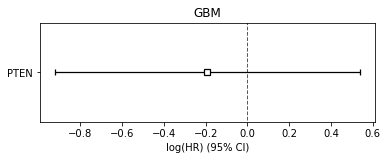

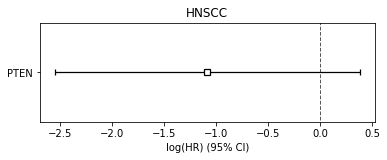

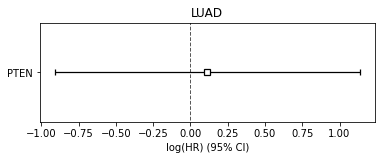

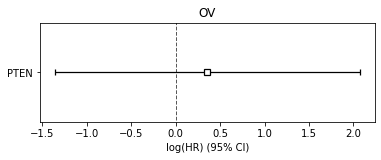

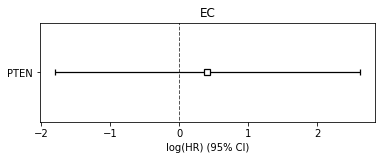

In [48]:
for cancer in new_dfs:
    df = new_dfs[cancer]
    
    cph = CoxPHFitter()
    cph.fit(df, duration_col = "days_to_last_contact_or_death", 
            event_col = "vital_status") 
    
    plt.figure()
    ax = plt.subplot(211) # height, width, 
    plt.title(cancer)
    cph.plot(ax = ax)